# Import Needed Packages

In [2]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
%matplotlib inline

# Markov Chain Time Series Generator + Examples

In [3]:
# P is the (k x k) transition matrix
# S is the vector of averages for each state (of length k)
# sigma is the shared variance
# n is the number of points to generate (length of time series)
# if debug = True, return state_gen rather than time_series.
def mkv_to_ts(P, S, sigma = 1, n = 10000, debug=False):
    k = len(S)
    base_matrix = np.tile(S, (n, 1)).T
    noise_matrix = np.random.normal(0, sigma, (k, n))
    full_matrix = base_matrix + noise_matrix
    
    state_gen = np.empty(n, dtype = np.int32)
    state_gen[0] = 0
    for i in range(1, n):
        state_gen[i] = np.random.choice(k, p=P[state_gen[i-1]])
    return state_gen if debug else np.choose(state_gen, full_matrix)

In [4]:
# Define example parameters:

# Transition Probabilities:
# Entry (i, j) = P(S_{t+1} = j | S_t = i)
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])

# Emission Mean for each State
S = np.array([5, 0, -5])

Text(0, 0.5, 'y_t')

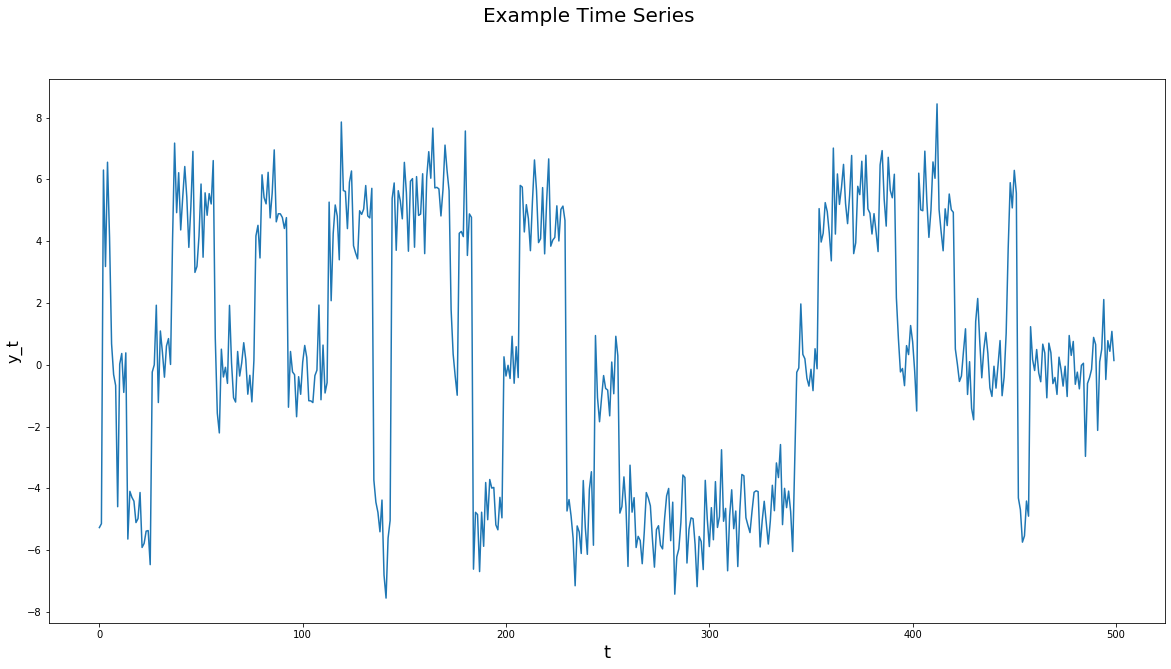

In [49]:
# generate time series and plot
# ts = mkv_to_ts(P, S, n=500)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Example Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)


# Checks that stationary distribution ~ MCTS

In [5]:
# Sanity Check:
# First, find the stationary distribution:

S, U = np.linalg.eig(P.T)
stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
stat_dist = stationary / np.sum(stationary)

# Second, print the percent time spent in each state
its = 10 # the number of times the time series are generated

accum = np.zeros_like(stat_dist)
for i in range(its):
    state_gen = mkv_to_ts(P, S, n=10000, debug=True)
    val_counts = np.unique(state_gen, return_counts=True)[1]
    accum += val_counts/np.sum(val_counts)
approx_dist = accum/its

print("Stationary Distribution: " + str(stat_dist))
print("Approx Distribution: " + str(approx_dist))

Stationary Distribution: [0.29032258 0.33870968 0.37096774]
Approx Distribution: [0.28855 0.34264 0.36881]


# Import e_divisive

In [8]:
# pip install git+https://github.com/egoolish/ecp_python
from ecp import e_divisive, e_agglomerative

# Define a MCTS and Run Basic e_divisive

Estimated Number of Change Points: 30.0
Minimum Size before Change: 2
Time:  1.3984529972076416
Found Change Points: 30


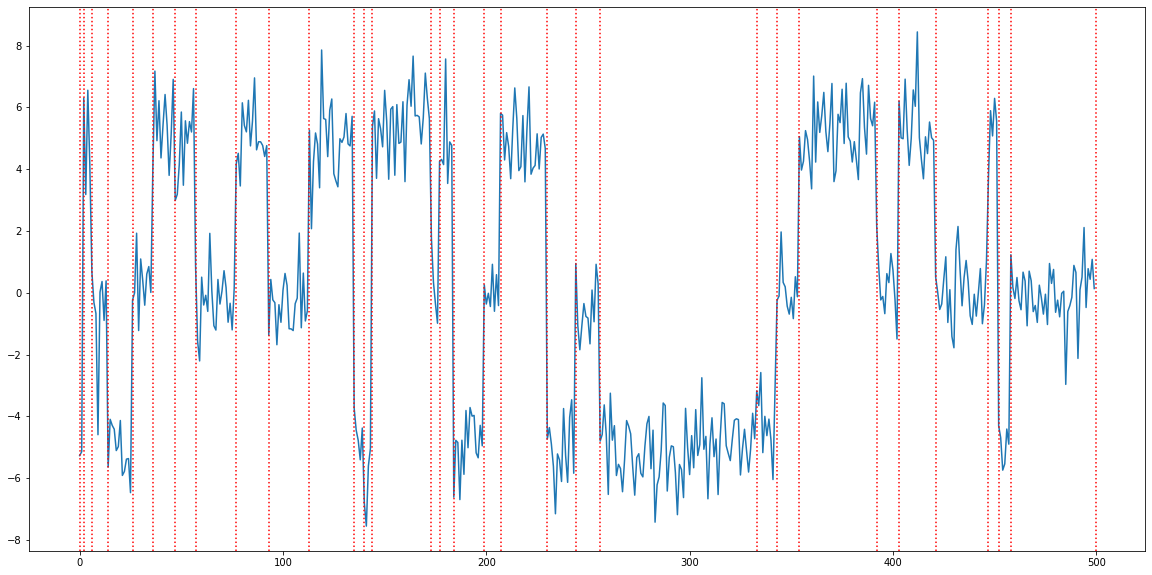

In [48]:
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts = mkv_to_ts(P, S, n=N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
# sol_dict = e_agglomerative.e_agglo(X = np.reshape(ts, (len(ts), 1)), alpha=2, penalty=lambda x : -500)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

For each segment from the initial e_divisive run, finds the mean.

In [50]:
clusters = sol_dict['cluster']
print(len(clusters))
print(sol_dict['estimates'])
print(clusters)
uniq_vals = np.unique(clusters)
num_of_clusters = len(uniq_vals) #clusters[-1]+1

find_means = np.vectorize(lambda x : np.mean(ts[clusters == x]))
cluster_means = find_means(uniq_vals) #find_means(np.arange(num_of_clusters))
print(cluster_means)

500
[0, 2, 6, 14, 26, 36, 47, 57, 77, 93, 113, 135, 140, 144, 173, 177, 184, 199, 207, 230, 244, 256, 333, 343, 354, 392, 403, 421, 447, 452, 458, 500]
[ 0  0  1  1  1  1  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3
  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  6
  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 12 12 12 12
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 14 14 14 14 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21

### Sorts the segment means, then runs e_divisive again:
This gives you an idea of how many total clusters there are / which segments are "legit" and which should be merged.

In [51]:
sort_c_idx = np.argsort(cluster_means).argsort()
sort_c = np.sort(cluster_means)

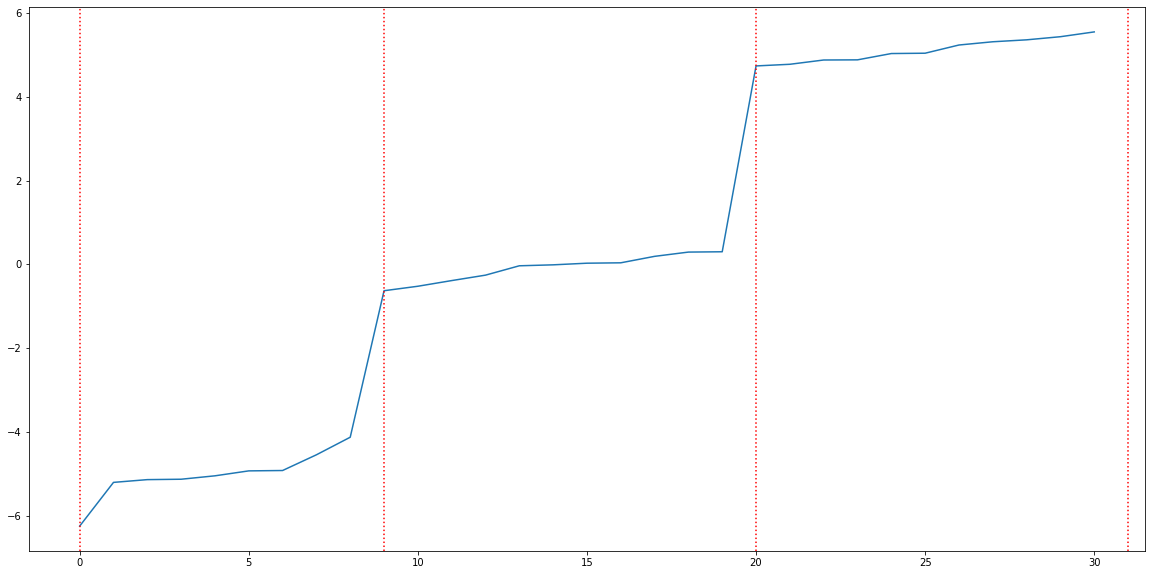

In [52]:
sol_dict_2 = e_divisive.e_divisive(X = np.reshape(sort_c, (len(sort_c), 1)), k=num_of_states-1, alpha=2, min_size=2)
plt.figure(figsize=(20,10))
plt.plot(sort_c)
for xc in sol_dict_2['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

### Assigns a cluster label to each initial segment.

In [53]:
cluster_labels = np.zeros(num_of_clusters, dtype=np.int32)
ests = sol_dict_2['estimates']
for i in range(1, len(ests)):
    cluster_labels[(sort_c_idx >= ests[i-1]) & (sort_c_idx < ests[i])] = i - 1

print(cluster_labels)

[0 2 1 0 1 2 2 1 2 1 2 0 0 2 1 2 0 1 2 0 1 0 0 1 2 1 2 1 2 0 1]


### Prints initial segment splits, then uses the above labels to propose new segment splits:
Idea: if two adjacent segments have the same label, then remove their segment split from the list.

In [54]:
print(sol_dict['estimates'])
new_ests = [sol_dict['estimates'][0]]
new_labs = [cluster_labels[0]]
for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != cluster_labels[i-1]:
        new_ests.append(sol_dict['estimates'][i])
        new_labs.append(cluster_labels[i])
new_ests.append(sol_dict['estimates'][-1])
final_ests = np.array(new_ests)
new_labs = np.array(new_labs)
print(final_ests)

[0, 2, 6, 14, 26, 36, 47, 57, 77, 93, 113, 135, 140, 144, 173, 177, 184, 199, 207, 230, 244, 256, 333, 343, 354, 392, 403, 421, 447, 452, 458, 500]
[  0   2   6  14  26  36  57  77  93 113 135 144 173 177 184 199 207 230
 244 256 343 354 392 403 421 447 452 458 500]


## Plots Merged Segments

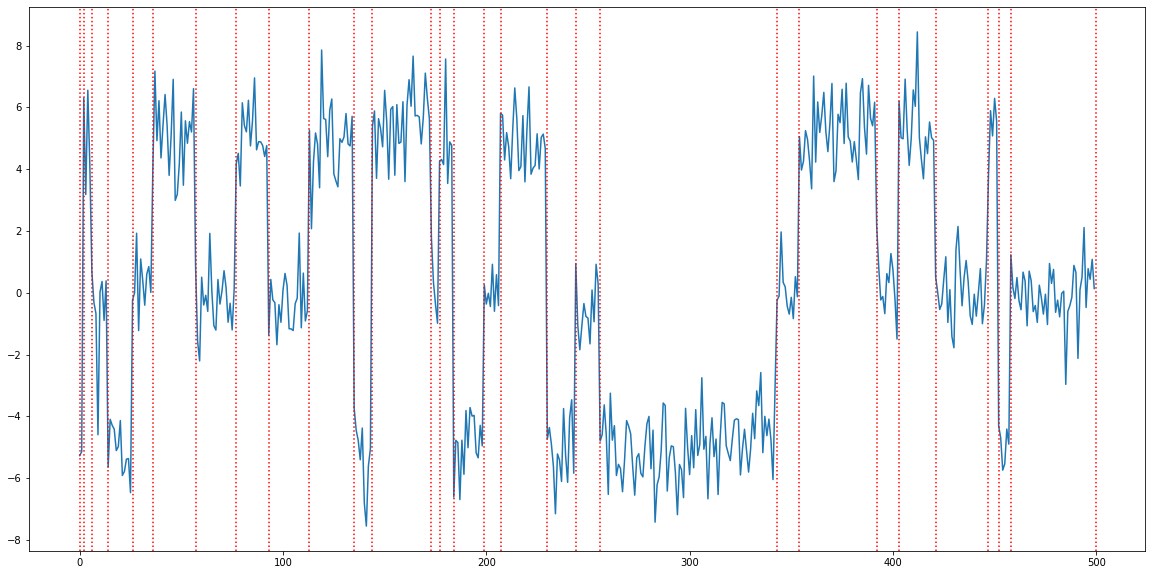

In [55]:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')

avg_time: for each state, find the length of an average stay in that state.

Use this to calculate P_{i, i} -- the probability of staying in the same state. This is P_diag

In [56]:
lens = np.diff(final_ests)
find_avg_time = np.vectorize(lambda x : np.mean(lens[new_labs == x]))
avg_times = find_avg_time(np.arange(num_of_states))

print(avg_times) #P_{i, i} = (x - 1)/x
P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)
print(P_diag)

[20.71428571 15.63636364 18.3       ]
[0.95172414 0.93604651 0.94535519]


Count the total number of times we go from a state i to any other state.

Also count the number of times we go from a state i to a specific state j.

P_{i, j} is proportional to (# of times we go from i to j)/(# of times we go from i to any other state).

To calculate P_{i, j} exactly, see how much wiggle room we have (1 - P_{i, i}). Then fill up that wiggle room with a normalized version of the above ratio.

In [57]:
est_P = np.zeros((num_of_states, num_of_states))
for i in range(1, len(cluster_labels)):
    est_P[cluster_labels[i-1], cluster_labels[i]] += 1
np.fill_diagonal(est_P, 0)
est_P = normalize(est_P, axis = 1, norm='l1')
est_P = (est_P.T*(1 - P_diag)).T
np.fill_diagonal(est_P, P_diag)
print(est_P)

[[0.95172414 0.03448276 0.0137931 ]
 [0.0127907  0.93604651 0.05116279]
 [0.02185792 0.03278689 0.94535519]]


# Updates cluster labels, then for each label, finds its average across all visits.

In [60]:
print(final_ests)
final_clusters = np.repeat(np.arange(0,len(np.diff(final_ests))), np.diff(final_ests))
print(len(final_clusters))
print(len(ts))
find_seg_sums = np.vectorize(lambda x : np.sum(ts[final_clusters == x]))
seg_sums = find_seg_sums(np.arange(final_clusters[-1]+1))

print(seg_sums)
find_time = np.vectorize(lambda x: np.sum(lens[new_labs == x]))
total_times = find_time(np.arange(num_of_states))

find_state_sums = np.vectorize(lambda x: np.sum(seg_sums[new_labs == x]))
est_S = find_state_sums(np.arange(num_of_states))/total_times
print(est_S)



[  0   2   6  14  26  36  57  77  93 113 135 144 173 177 184 199 207 230
 244 256 343 354 392 403 421 447 452 458 500]
500
500
[-1.04160465e+01  2.01566845e+01 -5.02744915e+00 -6.15927219e+01
  3.02615865e+00  1.07287122e+02 -5.12090884e+00  8.07535632e+01
 -7.72024029e+00  1.07547546e+02 -4.77546270e+01  1.61128600e+02
  7.72582184e-01  3.34788289e+01 -7.38656889e+01 -7.77793981e-02
  1.12351248e+02 -7.19910336e+01 -6.25706253e+00 -4.30226717e+02
  4.26237632e-01  1.99236741e+02  3.24424577e+00  9.66042298e+01
  7.63541920e-01  2.66027816e+01 -2.95986646e+01 -1.36778885e+00]
[-5.00307241 -0.10080502  5.16473959]


# Prints Comparison between Actual/Estimated P and S

Actual P: 
[[0.95 0.02 0.03]
 [0.01 0.95 0.04]
 [0.03 0.03 0.94]]
Estimated P: 
[[0.95172414 0.03448276 0.0137931 ]
 [0.0127907  0.93604651 0.05116279]
 [0.02185792 0.03278689 0.94535519]]

Point Labels: 


NameError: name 'point_labels' is not defined

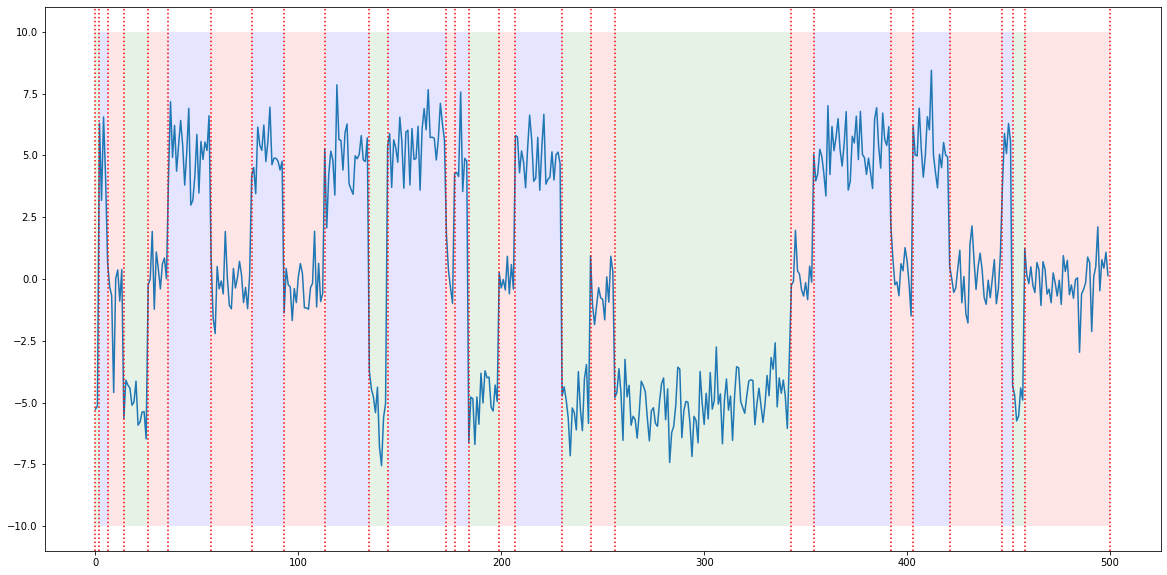

In [61]:
#Final Solution:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')
for i in range(1, len(final_ests)):
    if new_labs[i-1] == 0:
        plt.fill_betweenx([-10, 10], final_ests[i-1], final_ests[i], facecolor='green', alpha=0.10)
    elif new_labs[i-1] == 1:
        plt.fill_betweenx([-10, 10], final_ests[i-1], final_ests[i], facecolor='red', alpha=0.10)
    else:
        plt.fill_betweenx([-10, 10], final_ests[i-1], final_ests[i], facecolor='blue', alpha=0.10)

print("Actual P: ")
print(P)
print("Estimated P: ")
print(est_P)
print()
print("Actual S: ")
print(S)
print("Estimated S: ")
print(est_S)

### Generates a home state time series (The chain travels occasionally to unique other states, but always returns to a home state)

In [ ]:
def return_state_ts(hs_mean=0, hs_stay_p = 0.995, away_stay_p = 0.99, sigma = 1, n = 1000):
    ts = np.zeros(n)
    in_hs = True
    
    away_low = 5
    away_high = 15
    
    away_mean = np.random.uniform(away_low, away_high)
    for i in range(n):
        noise = np.random.normal(0, sigma)
        if in_hs:
            ts[i] = hs_mean + noise
            if np.random.uniform(0, 1) > hs_stay_p:
                in_hs = False
                away_mean = np.random.uniform(away_low, away_high)
        else:
            ts[i] = away_mean + noise
            if np.random.uniform(0, 1) > away_stay_p:
                in_hs = True
    return ts

### Plots an example of the home state time series

In [ ]:
ts = return_state_ts(n=5000)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Home State Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)


### Runs e_divisive on an example of the home_state time series

In [ ]:
stay_home_P = 0.995
home_mean = 0
noise = 1

N = 2000
K = int(N/(1/(1 - stay_home_P))) + N/100
ms = 2

ts = return_state_ts(hs_mean = home_mean, hs_stay_p = stay_home_P, sigma = noise, n = N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')